In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridintersect import GridIntersect
#import pyemu

from shapely.geometry import Polygon, Point
import shapefile
from shapely.prepared import prep

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

In [7]:
org_model_ws = os.path.join('..', 'temp_flopy_lr')
os.listdir(org_model_ws)

['experimental.cbb',
 'experimental.disv',
 'experimental.disv.grb',
 'experimental.ghb',
 'experimental.hds',
 'experimental.ic',
 'experimental.ims',
 'experimental.lst',
 'experimental.nam',
 'experimental.npf',
 'experimental.obs',
 'experimental.oc',
 'experimental.rch',
 'experimental.sfr',
 'experimental.sfr.bud',
 'experimental.sfr.obs',
 'experimental.sto',
 'experimental.tdis',
 'experimental_leakage.sfr.obs',
 'head.obs.csv',
 'mfsim.lst',
 'mfsim.nam',
 'rch.ts',
 'sfr.obs.csv',
 'sfr_leakage.obs.csv']

In [8]:
tmp_model_ws = os.path.join('..', 'temp_ml_param')
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['experimental.cbb',
 'experimental.disv',
 'experimental.disv.grb',
 'experimental.ghb',
 'experimental.hds',
 'experimental.ic',
 'experimental.ims',
 'experimental.lst',
 'experimental.nam',
 'experimental.npf',
 'experimental.obs',
 'experimental.oc',
 'experimental.rch',
 'experimental.sfr',
 'experimental.sfr.bud',
 'experimental.sfr.obs',
 'experimental.sto',
 'experimental.tdis',
 'experimental_leakage.sfr.obs',
 'head.obs.csv',
 'mfsim.lst',
 'mfsim.nam',
 'rch.ts',
 'sfr.obs.csv',
 'sfr_leakage.obs.csv']

In [9]:
ml_name = 'experimental'

In [10]:
loaded_sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), tmp_model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package sto...
    loading package ghb...
    loading package sfr...
    loading package obs...
    loading package rch...
  loading ims package experimental...


In [11]:
loaded_sim.set_all_data_external(True)

In [12]:
loaded_sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package experimental...
  writing model experimental...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package ghb...
    writing package sfr_obs...
    writing package sfr...
    writing package gwf_obs...
    writing package rch_ts...
    writing package rch...


In [13]:
mdl = loaded_sim.get_model('experimental')

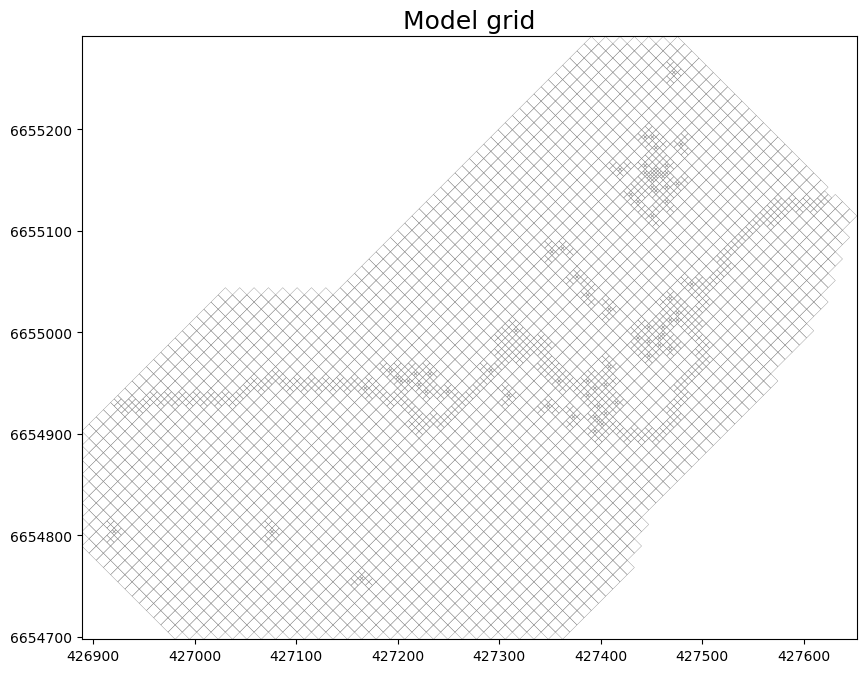

In [14]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Model grid', fontsize=18)

mapview = flopy.plot.PlotMapView(mdl, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

plt.show()

## Generate pilot points
3D-pilot points will be generated for the following areal properties:
- SY & SS (perhaps SS could be skipped?)
- Porosity and possibly diffusion/dispersion and any other parameter needed to represent transport
- Kh and Kz

In addition, pilot points will be generated along the following linear features:
- Streambed hydraulic conductivity along Creek Örbäcken (SFR package)
- GHB conductance

### 3D pilot points
Because we want to do a data-worth analysis, we should consider the total amount of pilot points to be employed to find a suitable compromise between adjustable parameters and model run-time.

For this reason, we will create different sets of pilot points for each parameter type (in order to not use an exessive amount of pps).

Sy, SS and possibly porosity (along with other parameters that govern transport) could be parameterized using a coarser pp-spacing, so let's start with that.

However, before we start, let's import the observation locations, so that we can see how the pilot points will be located in relation to them:

In [15]:
sfr_obs = pd.read_excel(os.path.join(observations_pth, 'obs_flow_and_stage.xlsx'))
head_obs = pd.read_excel(os.path.join(observations_pth, 'obs_head_per_layer.xlsx')).drop_duplicates(subset=['POINT_X', 'POINT_Y'])
head_obs['TYPE'] = 'HEAD'

In [16]:
obs_points = pd.concat([head_obs, sfr_obs])
display(obs_points)

,NAME,POINT_X,POINT_Y,LAYER,TYPE
0,B9-2,426918.374000,6.654803e+06,1.0,HEAD
1,B10-2,427074.709423,6.654805e+06,1.0,HEAD
2,B12-1,427448.188505,6.655156e+06,1.0,HEAD
3,B16-1,427409.547301,6.655023e+06,1.0,HEAD
4,B2-1,427384.172044,6.655037e+06,1.0,HEAD
...,...,...,...,...,...
2,NI15-O46-STG,427316.293421,6.655000e+06,NaN,STAGE
3,NI15-O47-STG,427294.946661,6.654962e+06,NaN,STAGE
4,NI15-O48-STG,427166.670722,6.654947e+06,NaN,STAGE
5,GAGE-1,427070.614000,6.654949e+06,NaN,INFLOW


#### Coarse 3D pilot points
Let's create the coarse pilot point distribution:

In [17]:
ml_boundary = shapefile.Reader(os.path.join(shapefile_pth, 'ml_boundary.shp')) # Model boundary shapefile
mlb_shape = np.array(np.rint(ml_boundary.shapeRecords()[0].shape.points)) # Model boundary array

Instantiate a shapely polygon of the model boundary:

In [18]:
mlb_shapely = Polygon(mlb_shape)

Create prepared polygon of the model boundary:

In [19]:
mlb_shapely_prep = prep(mlb_shapely)

Construct a rectangular mesh of points:

In [326]:
xmin, xmax, ymin, ymax = 426900, 427700, 6654650, 6655350 # These are the same coordinates used to construct the base-grid
resolution = 12.5 # Equal space (in meters) between pilot points
basepoints = []
for lat in np.arange(xmin, xmax, resolution):
    for lon in np.arange(ymin, ymax, resolution):
        basepoints.append(Point((round(lat,4), round(lon,4))))

Use the shapely `contains` (point-in-polygon method) to select points inside the model boundary:

In [327]:
basepip = [] # Basepoints in polygon
for point in basepoints:
    if mlb_shapely_prep.contains(point):
        basepip.append(point)
print(f'Number of points per layer: {len(basepip)}') # We need to extend it into three dimensions

Number of points per layer: 1673


Plot the position of the pilot points on top of the model grid:

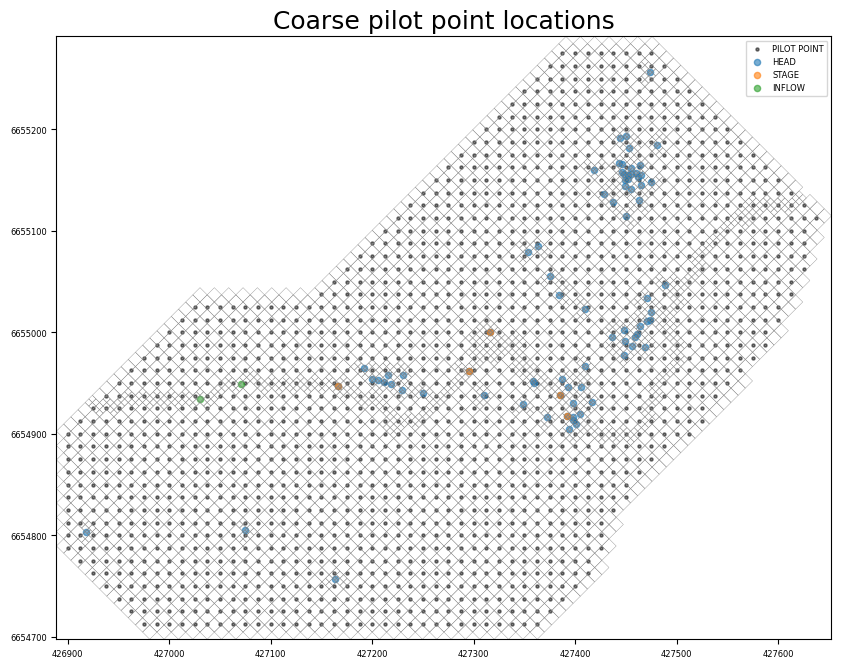

In [328]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Coarse pilot point locations', fontsize=18)

mapview = flopy.plot.PlotMapView(mdl, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

x = np.array([i.coords[0] for i in basepip])[:,0]
y = np.array([i.coords[0] for i in basepip])[:,1]
plt.scatter(x, y, s=5, c='black', alpha=0.5, label='PILOT POINT')

for category in obs_points['TYPE'].unique():
    x = obs_points.loc[obs_points['TYPE'] == category]['POINT_X']
    y = obs_points.loc[obs_points['TYPE'] == category]['POINT_Y']
    ax.scatter(x, y, s=20, alpha=0.6, label=category)


    
plt.legend()
plt.show()

These points now need to be assigned a z-value, since we are going to use 3D-pilot points. To do this, we will need to intersect the model grid and retrieve the z-values of each layer, so that a copy of these pps can be positioned in each of the three layers:

In [329]:
ix = GridIntersect(mdl.modelgrid)

In [330]:
pp_intersect = {
    'cellids': [],
    'vertices': [],
    'ixshapes': [],
}
for point in basepip:
    pp_intersect['cellids'].append(ix.intersect(point).cellids[0])
    pp_intersect['vertices'].append(ix.intersect(point).vertices[0])
    pp_intersect['ixshapes'].append(ix.intersect(point).ixshapes[0])

In [331]:
pp_intersect = pd.DataFrame(pp_intersect)
display(pp_intersect)

,cellids,vertices,ixshapes
0,264,"((426900.0, 6654787.5),)",POINT (426900 6654787.5)
1,265,"((426900.0, 6654800.0),)",POINT (426900 6654800)
2,225,"((426900.0, 6654812.5),)",POINT (426900 6654812.5)
3,187,"((426900.0, 6654825.0),)",POINT (426900 6654825)
4,151,"((426900.0, 6654837.5),)",POINT (426900 6654837.5)
...,...,...,...
1668,3428,"((427625.0, 6655087.5),)",POINT (427625 6655087.5)
1669,3429,"((427625.0, 6655100.0),)",POINT (427625 6655100)
1670,3349,"((427625.0, 6655112.5),)",POINT (427625 6655112.5)
1671,3281,"((427625.0, 6655125.0),)",POINT (427625 6655125)


We can see that the order is respected:

In [332]:
[i.coords[0] for i in basepip][:5]

[(426900.0, 6654787.5),
 (426900.0, 6654800.0),
 (426900.0, 6654812.5),
 (426900.0, 6654825.0),
 (426900.0, 6654837.5)]

Let's use the cellids to sample pilot point elevations (**this takes about 2 minutes on my laptop for 295 cells** and could/should probably be speed up somehow - considering it has to be done for top, botm1, botm2 and botm3):

In [333]:
def get_grid_elevation(elevation_array, index_array):
    '''
    returns list of elevations
    '''
    
    elevations = list(elevation_array)
    indices = list(index_array)
    
    return [elevation_array[i] for i in index_array]

In [334]:
pp_intersect['top'] = get_grid_elevation(elevation_array = mdl.modelgrid.top, index_array=pp_intersect['cellids'])

In [335]:
pp_intersect['botm_1'] = get_grid_elevation(mdl.modelgrid.botm[0], pp_intersect['cellids'])
pp_intersect['botm_2'] = get_grid_elevation(mdl.modelgrid.botm[1], pp_intersect['cellids'])
pp_intersect['botm_3'] = get_grid_elevation(mdl.modelgrid.botm[2], pp_intersect['cellids'])

In [336]:
pp_intersect

,cellids,vertices,ixshapes,top,botm_1,botm_2,botm_3
0,264,"((426900.0, 6654787.5),)",POINT (426900 6654787.5),135.564896,123.399101,118.538399,116.154800
1,265,"((426900.0, 6654800.0),)",POINT (426900 6654800),135.587494,123.422600,118.517899,116.072601
2,225,"((426900.0, 6654812.5),)",POINT (426900 6654812.5),135.399704,123.580299,118.665604,116.209297
3,187,"((426900.0, 6654825.0),)",POINT (426900 6654825),136.345703,123.778999,118.934097,116.524399
4,151,"((426900.0, 6654837.5),)",POINT (426900 6654837.5),136.452103,124.676903,119.969200,117.691200
...,...,...,...,...,...,...,...
1668,3428,"((427625.0, 6655087.5),)",POINT (427625 6655087.5),151.894897,140.151703,137.376007,135.637100
1669,3429,"((427625.0, 6655100.0),)",POINT (427625 6655100),150.945602,140.039505,137.340393,135.564407
1670,3349,"((427625.0, 6655112.5),)",POINT (427625 6655112.5),146.813599,139.686600,137.110504,135.515900
1671,3281,"((427625.0, 6655125.0),)",POINT (427625 6655125),143.623596,139.609497,137.186600,135.645599


Create pps in-between the layer boundaries (i.e. vertically centered in the cells):

In [337]:
pp_intersect['pps_l1'] = (pp_intersect['top'] + pp_intersect['botm_1']) / 2

In [338]:
pp_intersect['pps_l2'] = (pp_intersect['botm_1'] + pp_intersect['botm_2']) / 2

In [339]:
pp_intersect['pps_l3'] = (pp_intersect['botm_2'] + pp_intersect['botm_3']) / 2

In [340]:
display(pp_intersect)

,cellids,vertices,ixshapes,top,botm_1,botm_2,botm_3,pps_l1,pps_l2,pps_l3
0,264,"((426900.0, 6654787.5),)",POINT (426900 6654787.5),135.564896,123.399101,118.538399,116.154800,129.481998,120.968750,117.346600
1,265,"((426900.0, 6654800.0),)",POINT (426900 6654800),135.587494,123.422600,118.517899,116.072601,129.505047,120.970249,117.295250
2,225,"((426900.0, 6654812.5),)",POINT (426900 6654812.5),135.399704,123.580299,118.665604,116.209297,129.490002,121.122952,117.437450
3,187,"((426900.0, 6654825.0),)",POINT (426900 6654825),136.345703,123.778999,118.934097,116.524399,130.062351,121.356548,117.729248
4,151,"((426900.0, 6654837.5),)",POINT (426900 6654837.5),136.452103,124.676903,119.969200,117.691200,130.564503,122.323051,118.830200
...,...,...,...,...,...,...,...,...,...,...
1668,3428,"((427625.0, 6655087.5),)",POINT (427625 6655087.5),151.894897,140.151703,137.376007,135.637100,146.023300,138.763855,136.506554
1669,3429,"((427625.0, 6655100.0),)",POINT (427625 6655100),150.945602,140.039505,137.340393,135.564407,145.492554,138.689949,136.452400
1670,3349,"((427625.0, 6655112.5),)",POINT (427625 6655112.5),146.813599,139.686600,137.110504,135.515900,143.250099,138.398552,136.313202
1671,3281,"((427625.0, 6655125.0),)",POINT (427625 6655125),143.623596,139.609497,137.186600,135.645599,141.616547,138.398048,136.416100


Add x, y and clean up df:

In [341]:
pp_intersect['x'] = np.array([i.coords[0] for i in basepip])[:,0]
pp_intersect['y'] = np.array([i.coords[0] for i in basepip])[:,1]

In [342]:
pp_intersect = pp_intersect[['x', 'y', 'pps_l1', 'pps_l2', 'pps_l3']]

In [343]:
pp_intersect

,x,y,pps_l1,pps_l2,pps_l3
0,426900.0,6654787.5,129.481998,120.968750,117.346600
1,426900.0,6654800.0,129.505047,120.970249,117.295250
2,426900.0,6654812.5,129.490002,121.122952,117.437450
3,426900.0,6654825.0,130.062351,121.356548,117.729248
4,426900.0,6654837.5,130.564503,122.323051,118.830200
...,...,...,...,...,...
1668,427625.0,6655087.5,146.023300,138.763855,136.506554
1669,427625.0,6655100.0,145.492554,138.689949,136.452400
1670,427625.0,6655112.5,143.250099,138.398552,136.313202
1671,427625.0,6655125.0,141.616547,138.398048,136.416100


Visualize

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


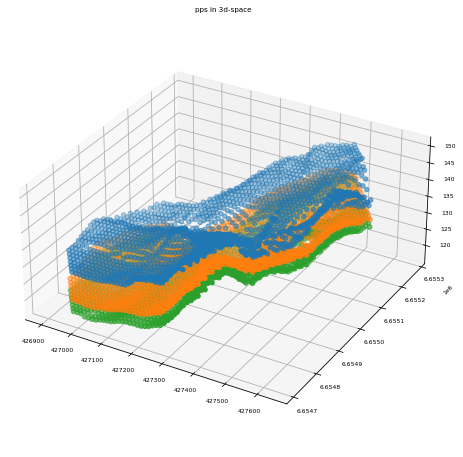

In [344]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = pyplot.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_box_aspect([2,2,1])

x, y = pp_intersect.x.values, pp_intersect.y.values

ax.scatter(x, y, pp_intersect.pps_l1.values)
ax.scatter(x, y, pp_intersect.pps_l2.values)
ax.scatter(x, y, pp_intersect.pps_l3.values)
plt.title('pps in 3d-space')
pyplot.show()

Convert the dataframe into a 3d pilot point file format:

In [345]:
pp_coarse3d = pd.melt(pp_intersect, id_vars=['x', 'y'], value_vars=['pps_l1', 'pps_l2', 'pps_l3'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


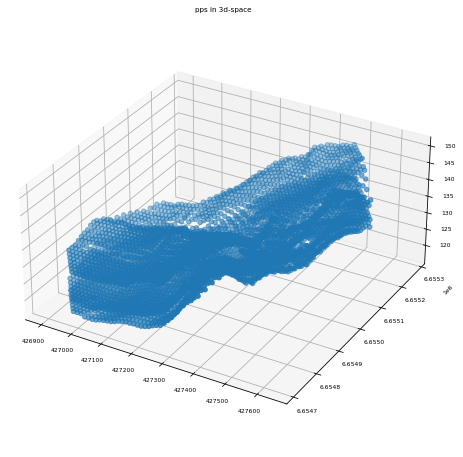

In [346]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = pyplot.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_box_aspect([2,2,1])

x, y = pp_coarse3d.x.values, pp_coarse3d.y.values

ax.scatter(x, y, pp_coarse3d.value.values)
plt.title('pps in 3d-space')
pyplot.show()

Insert columns:

In [347]:
pp_coarse3d['name'] = [f'ppc{i:04d}' for i in pp_coarse3d.index.values] # ppc = pilot point coarse.

In [348]:
pp_coarse3d[['zone','val']] = 1, 1
pp_coarse3d['z'] = pp_coarse3d['value']

In [349]:
pp_coarse3d['layer'] = [int(i[-1]) for i in pp_coarse3d['variable']]

In [350]:
pp_coarse3d = pp_coarse3d[['name', 'x', 'y', 'z', 'zone', 'val', 'layer']]

In [351]:
display(pp_coarse3d)

,name,x,y,z,zone,val,layer
0,ppc0000,426900.0,6654787.5,129.481998,1,1,1
1,ppc0001,426900.0,6654800.0,129.505047,1,1,1
2,ppc0002,426900.0,6654812.5,129.490002,1,1,1
3,ppc0003,426900.0,6654825.0,130.062351,1,1,1
4,ppc0004,426900.0,6654837.5,130.564503,1,1,1
...,...,...,...,...,...,...,...
5014,ppc5014,427625.0,6655087.5,136.506554,1,1,3
5015,ppc5015,427625.0,6655100.0,136.452400,1,1,3
5016,ppc5016,427625.0,6655112.5,136.313202,1,1,3
5017,ppc5017,427625.0,6655125.0,136.416100,1,1,3


In [352]:
from lumpyrem import run
#MKPPSTAT
# mkppstat requires no headers in ppoint file ...sigh...
pp_coarse3d.to_csv(os.path.join(tmp_model_ws, 'mkppoints3d_coarse.dat'),
                       header=None, index=False, sep='\t')

In [353]:
# Input for MKPPSTAT
# A (a)-factor of 1.5 is often reasonable. from tutorial 
npoints_h, npoints_v = 10, 10 # np-horizontal, np-vertical
a_h, a_v = 1.2, 1.2 # a-horizontal, a-vertical
# run MKPPSTAT
run.run_process(
    'mkppstat3d',
    path=tmp_model_ws,
    commands=['mkppoints3d_coarse.dat', npoints_h, a_h, npoints_v, a_v, 'ppstat3d_coarse.dat']
)

 
 Program MKPPSTAT3D writes a pilot points statistical specification file 
   based on a 3D pilot points file using local pilot point density to set 
   local variogram range.
 
 Enter name of 3D pilot points file:   - data for 5019 pilot points read from pilot points file 
    mkppoints3d_coarse.dat
 
 Enter no. of pilot points to compute local ave. hor. pp. sepn.:  Enter factor of ave. hor. sepn. for local variogram hor. "a" value: 
 Enter no. of pilot points to compute local ave. vert. pp. sepn.:  Enter factor of ave. vert. sepn. for local variogram vert. "a" value: 
 Enter name for 3D pilot point statistical spec. file:  - file ppstat3d_coarse.dat written ok
 



In [354]:
# run PPCOV3D_SVA - pilot point covariance 3d - spatially varying anisotropy
run.run_process(
    'ppcov3d_sva',
    path=tmp_model_ws,
    commands=['ppstat3d_coarse.dat', 'y', 1, 'x',  'cov3d_coarse.mat', '']
)

 
 Program PPCOV3D_SVA creates a covariance matrix file for 3D pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of 3D pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:  Working.....
  - data for 5019 pilot points read from file ppstat3d_coarse.dat
 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]:  Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix for parameter names (<Enter> if none): 
 Filling covariance matrix....
 Using SVD to assure positive definiteness of matrix....
 - file cov3d_coarse.mat written ok.



In [355]:
# Load cov mat file with Pyemu for further processing
import pyemu
covmat_coarse = pyemu.Cov.from_ascii(os.path.join(tmp_model_ws, "cov3d_coarse.mat"))

# This covaraince matrix can now be used as the base for all pilot point parameters. 
# Note that in this case the variance is 1, so it is easy to scale to a parameters prior varaince
# Depending on how you setup the scrpt, variance can be assigned at various stages (i.e. when running PPCOV_SVA, or by manipulating the matrix later)
# Note that parameter names (headers and row names) come from the parameter name sin the ppoint file. These can have a prefix added by PPCOV_SVA, or changed in the dataframe. The latter is more versatile.
covmat_coarse.to_dataframe().head()

,ppc0000,ppc0001,ppc0002,ppc0003,ppc0004,ppc0005,ppc0006,ppc0007,ppc0008,ppc0009,...,ppc5009,ppc5010,ppc5011,ppc5012,ppc5013,ppc5014,ppc5015,ppc5016,ppc5017,ppc5018
ppc0000,1.000000,0.352865,0.124515,0.043905,0.015474,0.005456,0.001924,0.000678,0.000239,0.000203,...,6.720642e-16,8.801095e-16,9.782411e-17,-6.377181e-16,4.319744e-16,8.299550e-16,3.262003e-16,2.836305e-16,4.307406e-16,6.570609e-17
ppc0001,0.352865,1.000000,0.352865,0.124385,0.043827,0.015453,0.005451,0.001919,0.000677,0.000239,...,-7.489010e-17,-3.821084e-16,1.223300e-17,-7.416157e-16,-1.168956e-16,5.682526e-16,-3.109038e-16,-2.337110e-16,3.017130e-16,-8.226549e-16
ppc0002,0.124515,0.352865,1.000000,0.352086,0.124029,0.043739,0.015433,0.005432,0.001915,0.000678,...,-2.011198e-16,-2.292342e-16,9.353268e-17,-8.232981e-16,-8.234003e-16,-3.928359e-16,-2.794868e-16,-5.810165e-16,-3.856596e-16,-5.855155e-16
ppc0003,0.043905,0.124385,0.352086,1.000000,0.352272,0.124229,0.043829,0.015428,0.005441,0.001925,...,-2.371678e-16,2.760523e-16,6.135446e-16,1.262779e-16,-3.542789e-17,1.048488e-16,4.546089e-16,-2.795184e-16,-1.745372e-16,2.256595e-16
ppc0004,0.015474,0.043827,0.124029,0.352272,1.000000,0.352646,0.124405,0.043798,0.015447,0.005462,...,-2.164180e-16,-1.410083e-16,3.583173e-16,5.287792e-16,-3.202255e-16,-3.013017e-16,-1.888056e-16,-4.968729e-16,-2.380803e-16,-3.185258e-16


Is this matrix only used during regularization?

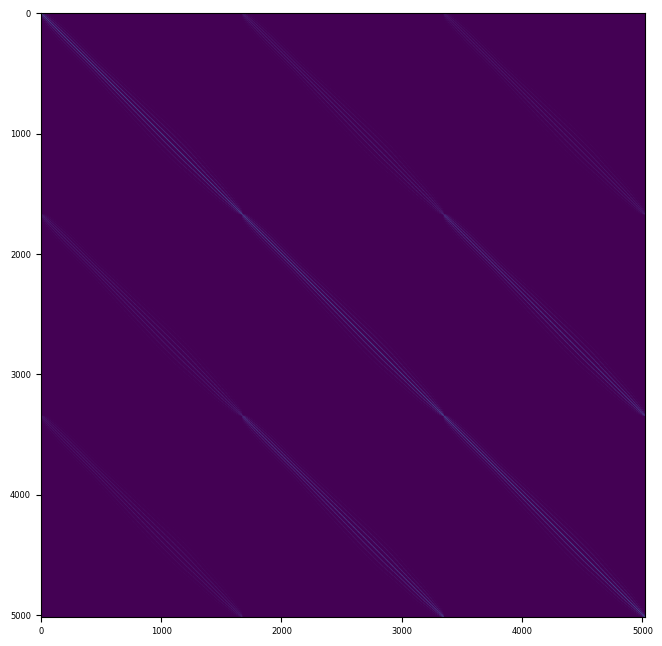

In [356]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(covmat_coarse.as_2d)

In [480]:
pp_coarse3d[['kh', 'kv', 'sy', 'ss']] = 86.4, 8.64, 0.2, 0.00001

In [481]:
pp_coarse3d.loc[pp_coarse3d['layer']==2, ['kh', 'kv', 'sy', 'ss']] = 1e-2, 1e-3, 0.2, 0.00001

pp_coarse3d.loc[pp_coarse3d['layer']==3, ['kh', 'kv', 'sy', 'ss']] = 50, 1, 0.2, 0.00001

In [482]:
pp_coarse3d

,name,x,y,z,zone,val,layer,kh,kv,sy,ss
0,ppc0000,426900.0,6654787.5,129.481998,1,1,1,86.4,8.64,0.2,0.00001
1,ppc0001,426900.0,6654800.0,129.505047,1,1,1,86.4,8.64,0.2,0.00001
2,ppc0002,426900.0,6654812.5,129.490002,1,1,1,86.4,8.64,0.2,0.00001
3,ppc0003,426900.0,6654825.0,130.062351,1,1,1,86.4,8.64,0.2,0.00001
4,ppc0004,426900.0,6654837.5,130.564503,1,1,1,86.4,8.64,0.2,0.00001
...,...,...,...,...,...,...,...,...,...,...,...
5014,ppc5014,427625.0,6655087.5,136.506554,1,1,3,50.0,1.00,0.2,0.00001
5015,ppc5015,427625.0,6655100.0,136.452400,1,1,3,50.0,1.00,0.2,0.00001
5016,ppc5016,427625.0,6655112.5,136.313202,1,1,3,50.0,1.00,0.2,0.00001
5017,ppc5017,427625.0,6655125.0,136.416100,1,1,3,50.0,1.00,0.2,0.00001


In [483]:
pp_coarse3d.to_csv(os.path.join(tmp_model_ws, 'pp3d_coarse.dat'),
                       header=None, index=False, sep='\t')

In [484]:
def write_plproc_script(filename, lines):

    with open(filename, 'w+') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

Write plproc script (is this necessary? wasnt this just done using ppcov3d_sva? ... at any rate, assigning a values based on results from ppcov3d_sva. Winging the angles based on what i know of the site (hoping I don't misrepresent this "expert" knowledge):

In [637]:
write_plproc_script(os.path.join(tmp_model_ws, 'plproc1.dat'), [
'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=experimental.disv.grb,    &
                            dimensions=3,                  &
                            slist_idomain = idomain,       &
                            slist_layernum = layer,        &
                            plist_bottom = bottom) # Is bottom needed?

### Read pilot-points file ###
cl_pp = read_list_file(file=pp3d_coarse.dat,               &
                       id_type=character,                  &
                       dimensions=3,                       &
                       slist=zone; col=5,                  &
                       slist=lyr; col=7,                   &
                       plist=kh_pp; col=8,                 &
                       plist=kv_pp; col=9,                 &
                       plist=sy_pp; col=10,                &
                       plist=ss_pp; col=11)


### Create CLIST partitions so that the function "write_model_input_file" writes ###
### a MODFLOW readable parameter file with the same length as                    ### 
### experimental.npf_k_layer1.txt                                                ###
### Is this the proper way to go about it?                                       ###
cl_mf_layer1 = cl_mf.partition_by_eqn(select=(layer==1))
cl_mf_layer2 = cl_mf.partition_by_eqn(select=(layer==2))
cl_mf_layer3 = cl_mf.partition_by_eqn(select=(layer==3))


### Calculate kriging factors for each CLIST partition ###
### If creating partitions is wrong, then this will be ###
### wrong as well...                                   ###


calc_kriging_factors_3d(target_clist=cl_mf,                   &
                        source_clist=cl_pp,                          &
                        file=ppfactors.dat,                         &
                        variogram=exponential,                       &
                        a_hmax=30000, a_hmin=30000, a_vert=3000,              &
                        ang1=0, ang2=0, ang3=0,                    &
                        kriging=ordinary,                            &
                        search_rad_max_hdir=1e15,                     &
                        search_rad_min_hdir=1e15,                      &
                        search_rad_vert=1e15,                          &
                        min_points=1,max_points=10)



### Write  ###
prop_mf=new_plist(reference_clist=cl_mf, value=1.0)

### kh PLIST for all cells###
prop_mf=kh_pp.krige_using_file(file='ppfactors.dat',transform='log')

### Write kh layer 1 ###
prop_mf_l1=prop_mf.partition_by_clist(clist=cl_mf_layer1)
write_model_input_file(template_file=gen_mf_array_l1.tpl, model_input_file=experimental.npf_k_layer1.txt)

### Write kh layer 2 ###
prop_mf_l2=prop_mf.partition_by_clist(clist=cl_mf_layer2)
write_model_input_file(template_file=gen_mf_array_l2.tpl, model_input_file=experimental.npf_k_layer2.txt)

### Write kh layer 3 ###
prop_mf_l3=prop_mf.partition_by_clist(clist=cl_mf_layer3)
write_model_input_file(template_file=gen_mf_array_l3.tpl, model_input_file=experimental.npf_k_layer3.txt)

### Write reports ###
report_all_entities(file=report1.dat)
cl_mf.report_dependent_lists(file='report2.dat')
'''
])

In [638]:
with open(os.path.join(tmp_model_ws, 'gen_mf_array_l1.tpl'), 'w+') as f:
    f.write('$#p prop_mf_l1.write_in_sequence(format="(1x,1pg18.11)")')

In [639]:
with open(os.path.join(tmp_model_ws, 'gen_mf_array_l2.tpl'), 'w+') as f:
    f.write('$#p prop_mf_l2.write_in_sequence(format="(1x,1pg18.11)")')

In [640]:
with open(os.path.join(tmp_model_ws, 'gen_mf_array_l3.tpl'), 'w+') as f:
    f.write('$#p prop_mf_l3.write_in_sequence(format="(1x,1pg18.11)")')

In [641]:
# run PLPROC
run.run_process(
    'plproc',
    path=tmp_model_ws,
    commands=['plproc1.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc1.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=experimental.disv.grb,dimensions=3,sli...
> cl_pp=read_list_file(file=pp3d_coarse.dat,id_type=character,dimension...
> cl_mf_layer1=cl_mf.partition_by_eqn(select=(layer==1))
> cl_mf_layer2=cl_mf.partition_by_eqn(select=(layer==2))
> cl_mf_layer3=cl_mf.partition_by_eqn(select=(layer==3))
> calc_kriging_factors_3d(target_clist=cl_mf,source_clist=cl_pp,file=pp...
> prop_mf=new_plist(reference_clist=cl_mf,value=1.0)
> prop_mf=kh_pp.krige_using_file(file='ppfactors.dat',transform='log')
> prop_mf_l1=prop_mf.partition_by_clist(clist=cl_mf_layer1)
> write_model_input_file(template_file=gen_mf_array_l1.tpl,model_input_...
> prop_mf_l2=prop_mf.partition_by_clist(clist=cl_mf_layer2)
> write_model_input_file(template_file=gen_mf_array_l2.tpl,model_input_...
> prop

ref files contain cells from all 3 layers... modflow outputs 1 file per layer. what to do?

In [642]:
#loaded_sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package sto...
    loading package ghb...
    loading package sfr...
    loading package obs...
    loading package rch...
  loading ims package experimental...


[<AxesSubplot:title={'center':'k layer 1'}>,
 <AxesSubplot:title={'center':'k layer 2'}>,
 <AxesSubplot:title={'center':'k layer 3'}>]

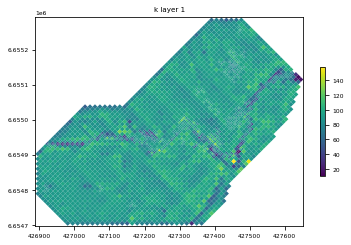

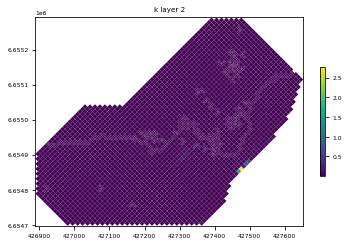

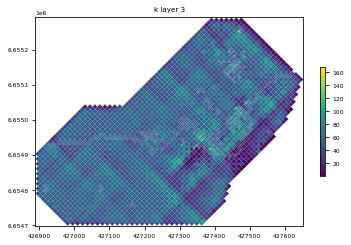

In [643]:
loaded_sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), tmp_model_ws)
loaded_sim.get_model().npf.k.plot(colorbar=True)

[<AxesSubplot:title={'center':'botm layer 1'}>,
 <AxesSubplot:title={'center':'botm layer 2'}>,
 <AxesSubplot:title={'center':'botm layer 3'}>]

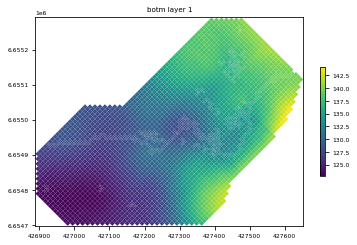

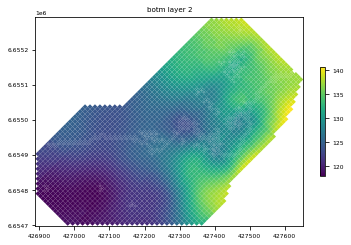

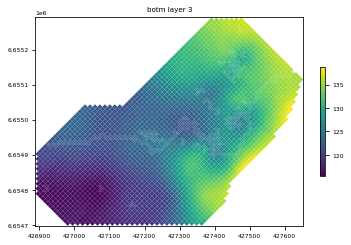

In [644]:
loaded_sim.get_model().disv.botm.plot(colorbar=True)

In [645]:
vgrid = loaded_sim.get_model().modelgrid

vgrid.xyzcellcenters


[array([426895.944, 426903.015, 426910.086, ..., 427412.132, 427419.203,
        427426.274]),
 array([6654902.55, 6654909.62, 6654916.69, ..., 6654754.06, 6654761.13,
        6654768.2 ]),
 array([[131.63895035, 131.41224671, 131.69750214, ..., 146.44564819,
         146.66045379, 146.81539917],
        [124.58855057, 124.85629654, 125.10085297, ..., 139.69395447,
         140.00770569, 140.25595093],
        [121.43045044, 121.72104645, 121.98655319, ..., 136.58724975,
         136.92595673, 137.20760345]])]

In [646]:
botm = vgrid.xyzcellcenters[-1]


thick = []
for idx, bot in enumerate(botm):
    if idx<2:
        thick.append(botm[idx] - botm[idx+1])

In [647]:
thick[1].min()

0.7304992699999957